<H1> LIBRARIES </H1>

In [4]:
!pip install xgboost

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
file_path = r"E:\Personal\UMD Notes\MSML 602_ DS\DS PROJ\US_Accidents.csv"

<h1> LOAD DATASET</h1>

In [8]:
# Load the dataset
data = pd.read_csv(file_path)

# Filter only data from 2019 and beyond
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')
data = data[data['Start_Time'].dt.year >= 2019]

<H1> EDA </H1>

In [10]:
# Import required libraries
import pandas as pd
import numpy as np

# General overview of the dataset
print("Basic Information:")
data.info()

# Summary statistics of numeric features
print("\nSummary Statistics:")
print(data.describe())

# Check for the distribution of target variable (Severity)
print("\nSeverity Distribution:")
print(data['Severity'].value_counts(normalize=True))

# Check for categorical columns and their unique values
print("\nUnique Values in Categorical Columns:")
categorical_cols = ['City', 'State', 'Wind_Direction', 'Weather_Condition', 
                    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
for col in categorical_cols:
    print(f"{col} - Unique Values: {data[col].nunique()}")

# Check missing values in the dataset
print("\nMissing Values in Dataset:")
print(data.isnull().sum())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Index: 4963691 entries, 512217 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               object        
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Air

<H1> DATA CLEANING

In [12]:
# Drop irrelevant columns that do not add value to the model or visualization
irrelevant_cols = ['ID', 'Description', 'Weather_Timestamp', 'Airport_Code']
data_cleaned = data.drop(columns=irrelevant_cols)

# Filter data to keep only rows from 2019 and above
data_cleaned['Start_Time'] = pd.to_datetime(data_cleaned['Start_Time'], errors='coerce')
data_cleaned = data_cleaned[data_cleaned['Start_Time'].dt.year >= 2019]

# Handle missing values by dropping columns with more than 40% missing data
missing_threshold = 0.4 * len(data_cleaned)
data_cleaned = data_cleaned.dropna(thresh=missing_threshold, axis=1)

# Impute missing numerical columns with their mean
for col in data_cleaned.select_dtypes(include=['float64']).columns:
    data_cleaned[col].fillna(data_cleaned[col].mean(), inplace=True)

# Impute missing categorical columns with mode (most frequent value)
for col in data_cleaned.select_dtypes(include=['object']).columns:
    data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)

# Confirm missing values are handled
print("\nRemaining Missing Values:")
print(data_cleaned.isnull().sum().sort_values(ascending=False))

C:\Users\mukul\AppData\Local\Temp\ipykernel_45332\3939835285.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[col].fillna(data_cleaned[col].mean(), inplace=True)
C:\Users\mukul\AppData\Local\Temp\ipykernel_45332\3939835285.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a


Remaining Missing Values:
Source                   0
Railway                  0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Roundabout               0
Severity                 0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Wind_Speed(mph)          0
Wind_Direction           0
Visibility(mi)           0
Pressure(in)             0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Street                   0
City                     0
County                   0
State                    0
Zipcode                  0
C

In [13]:
# Check the shape of the cleaned dataset
print(f"Dataset Shape after Cleaning: {data_cleaned.shape}")

# Display first few rows of the cleaned dataset to confirm changes
data_cleaned.head()

# Check the data types to ensure everything is in order
print("\nData Types:")
print(data_cleaned.dtypes)

# Ensure no missing values are left
print("\nMissing Values after Cleaning:")
print(data_cleaned.isnull().sum().sort_values(ascending=False))

Dataset Shape after Cleaning: (4963691, 42)

Data Types:
Source                           object
Severity                          int64
Start_Time               datetime64[ns]
End_Time                         object
Start_Lat                       float64
Start_Lng                       float64
End_Lat                         float64
End_Lng                         float64
Distance(mi)                    float64
Street                           object
City                             object
County                           object
State                            object
Zipcode                          object
Country                          object
Timezone                         object
Temperature(F)                  float64
Wind_Chill(F)                   float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64
Wind_Direction                   object
Wind_Speed(mph)                 float64
Precipitation(in)      

<b>DATA BALANCING

Our project focuses on geographical accident analysis (using Folium) and actionable insights for specific accident patterns—balancing the dataset isn’t strictly necessary.
After testing the final output, we can understand the biased nature even better due to higher volume of data.

<H1> Visualize with Plots</H1>

Distribution with severity levels

C:\Users\mukul\AppData\Local\Temp\ipykernel_45332\3005962849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='Severity', palette='coolwarm')


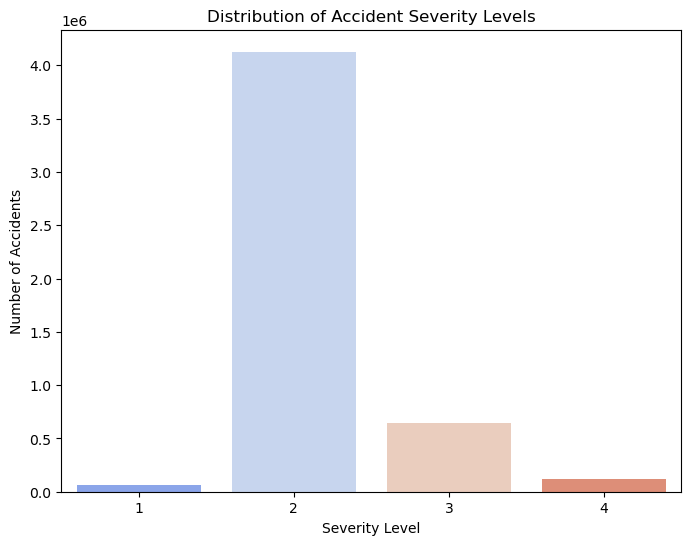

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Severity distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, x='Severity', palette='coolwarm')
plt.title('Distribution of Accident Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.show()

Accidents by Hour of Day

C:\Users\mukul\AppData\Local\Temp\ipykernel_45332\4205151277.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='Hour', palette='viridis')


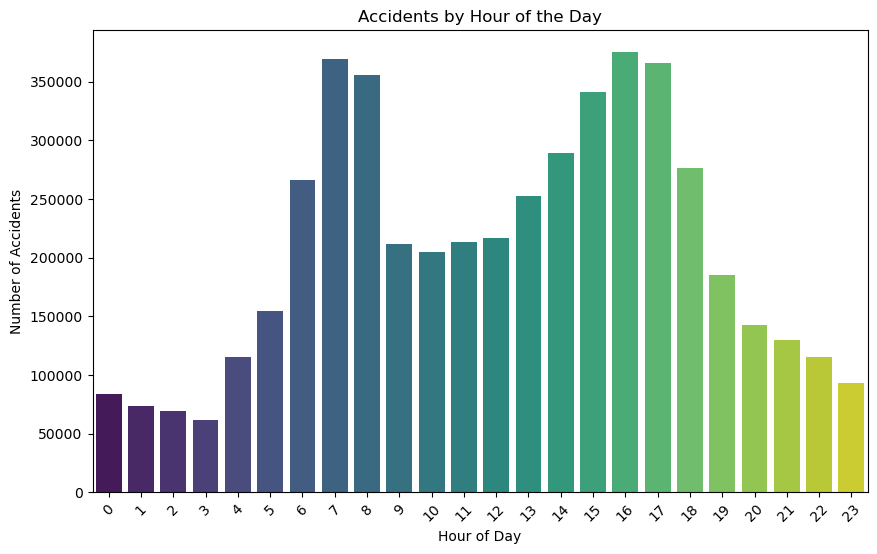

In [20]:
# Extract hour from Start_Time
data_cleaned['Hour'] = data_cleaned['Start_Time'].dt.hour

# Plot the distribution of accidents by hour
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Hour', palette='viridis')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

Temperature vs. Accident Severity

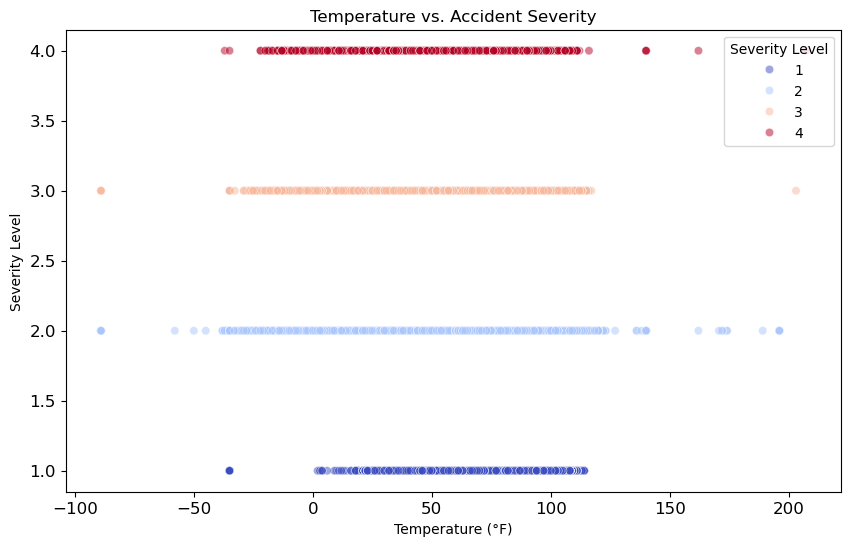

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature(F)', y='Severity', data=data_cleaned, alpha=0.5, hue='Severity', palette='coolwarm')
plt.title('Temperature vs. Accident Severity')
plt.xlabel('Temperature (°F)')
plt.ylabel('Severity Level')
plt.legend(title='Severity Level', loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Accidents by Weather Conditions

C:\Users\mukul\AppData\Local\Temp\ipykernel_8584\2270125855.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, y='Weather_Condition', order=data_cleaned['Weather_Condition'].value_counts().index, palette='magma')


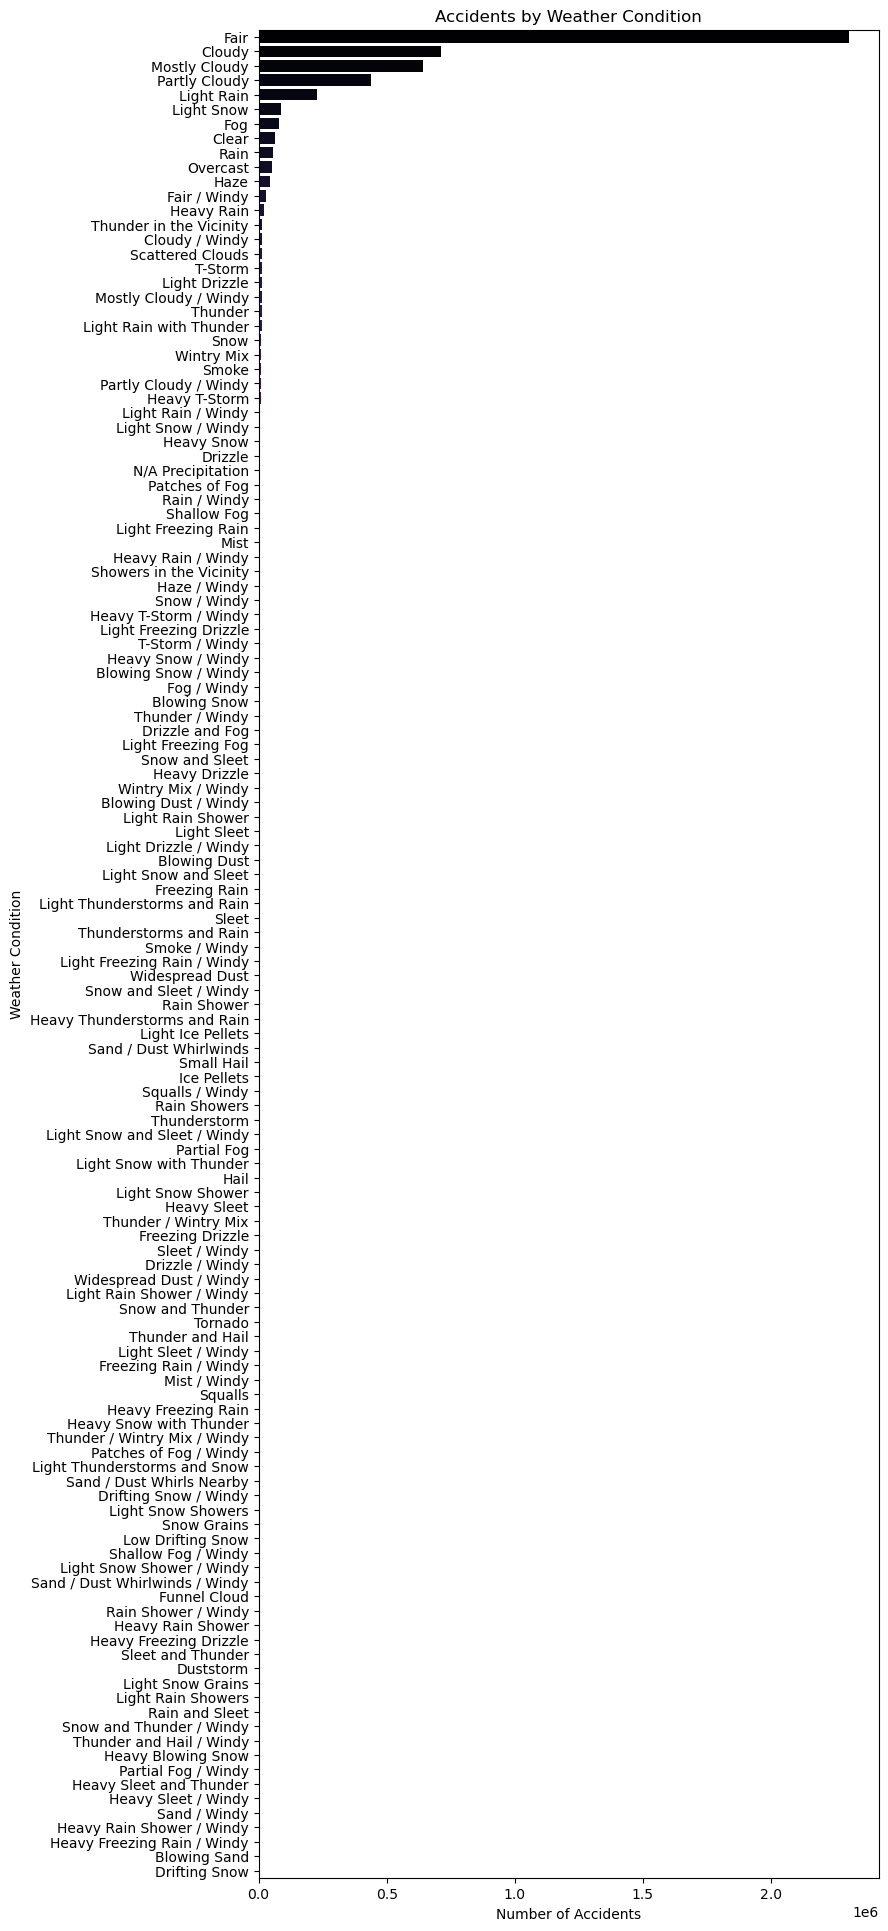

In [17]:
plt.figure(figsize=(8, 24))
sns.countplot(data=data_cleaned, y='Weather_Condition', order=data_cleaned['Weather_Condition'].value_counts().index, palette='magma')
plt.title('Accidents by Weather Condition')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.show()

Correlation Heatmap of Numerical Features

Numeric Columns: Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Hour'],
      dtype='object')


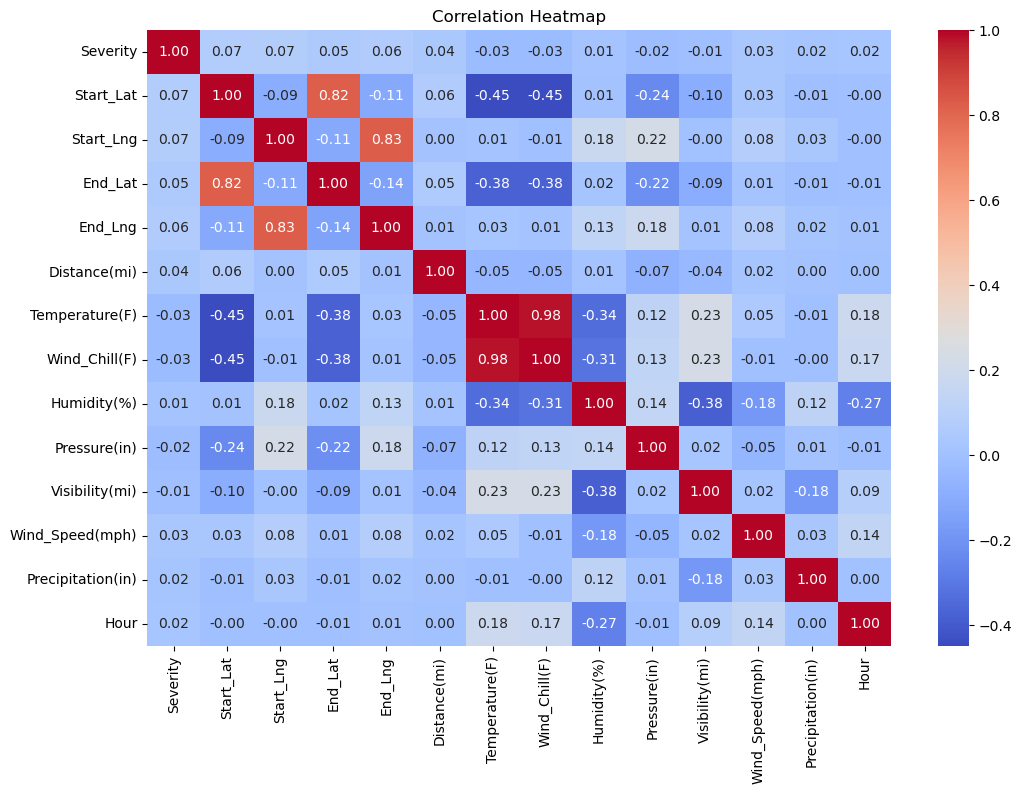

In [19]:
# Filter the dataset to include only numeric columns
numeric_data = data_cleaned.select_dtypes(include=['float64', 'int64', 'int32'])

# Check if we are working with the right subset
print(f"Numeric Columns: {numeric_data.columns}")

# Plot the heatmap using only numeric data
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
# Drop the unwanted columns to save memory and improve efficiency
columns_to_drop = [
    'Source', 'Street', 'County', 'Zipcode', 'Country', 
    'Timezone', 'End_Lat', 'End_Lng', 'Turning_Loop'
]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)

# Verify the remaining columns
print(f"Remaining Features: {len(data_cleaned.columns)}")
print(data_cleaned.columns)

Remaining Features: 34
Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'City', 'State', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Hour'],
      dtype='object')


SAVE CLEANED DATASET

In [23]:
# Save the cleaned data for future use
data_cleaned.to_csv('cleaned_accident_data.csv', index=False)
print("Cleaned dataset saved successfully!")

Cleaned dataset saved successfully!


<H1> Preprocessing & Feature Scaling</H1>

Splitting Data into Features and Labels

In [26]:
# Check which columns are available to drop
columns_to_drop = ['Severity', 'Start_Time', 'End_Time', 'ID', 'Description']
available_columns_to_drop = [col for col in columns_to_drop if col in data_cleaned.columns]

# Define features and target variable
X = data_cleaned.drop(available_columns_to_drop, axis=1)  # Drop only available columns
y = data_cleaned['Severity']

print(f"Features selected: {X.columns.tolist()}")

Features selected: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'City', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hour']


In [29]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training Data Shape: {X_train.shape}')
print(f'Testing Data Shape: {X_test.shape}')

Training Data Shape: (3970952, 31)
Testing Data Shape: (992739, 31)


Encoding Categorical Variables

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# List categorical columns to encode
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'  # Keep remaining numerical columns as is
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f'Encoded Training Data Shape: {X_train_encoded.shape}')

Encoded Training Data Shape: (3970952, 12794)


Feature Scaling (Standardization)

In [33]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with `with_mean=False` to handle sparse data safely
scaler = StandardScaler(with_mean=False)

# Apply scaling to the encoded features
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Feature scaling complete.")

Feature scaling complete.


<H1> MODEL TRAINING - RANDOM FOREST CLASSIFIER </H1>

WILL BE TESTED SOON DUE TO LACK OF MEMORY SIZE / ENSEMBLE METHODS ARE HIGHLY ADVISED FOR OUR PROJECT.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train_scaled, y_train)

print("Model training complete.")

Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test data
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Folium Map Visualization for Predictions

In [ ]:
import folium

# Create a map centered on the average latitude and longitude
accident_map = folium.Map(location=[data_cleaned['Start_Lat'].mean(), data_cleaned['Start_Lng'].mean()], zoom_start=5)

# Add points to the map
for i, row in data_cleaned.sample(500).iterrows():  # Plot a sample for performance reasons
    folium.CircleMarker(
        location=[row['Start_Lat'], row['Start_Lng']],
        radius=5,
        color='red' if row['Severity'] == 4 else 'orange' if row['Severity'] == 3 else 'green',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(accident_map)

# Save the map as an HTML file
accident_map.save("accident_predictions_map.html")
print("Map saved as accident_predictions_map.html")

In [ ]:
from IPython.display import IFrame

# Display the saved map in the notebook
IFrame('accident_predictions_map.html', width=700, height=500)

<H1> MODEL TESTING </H1>

LOGISTIC REGRESSION

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate Logistic Regression
print("Logistic Regression - Accuracy on Training Data:", accuracy_score(y_train, log_reg.predict(X_train_scaled)))
print("Logistic Regression - Accuracy on Test Data:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_log))

Logistic Regression - Accuracy on Training Data: 0.8402939647721756
Logistic Regression - Accuracy on Test Data: 0.8393565680405424

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           1       0.16      0.00      0.00     13319
           2       0.85      0.99      0.91    825474
           3       0.62      0.14      0.23    129849
           4       0.38      0.02      0.04     24097

    accuracy                           0.84    992739
   macro avg       0.50      0.29      0.29    992739
weighted avg       0.80      0.84      0.79    992739



Interpretation: Logistic regression assumes that the data has a linear decision boundary, which seems to hold fairly well given the similar training and test accuracy. However, some classes (like Severity 1 and Severity 4) are poorly predicted, hinting that a linear model may struggle with non-linear complexities in the data.

DECISION TREE CLASSIFIER

In [40]:
from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)  # Limiting depth to prevent overfitting
dt_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate Decision Tree
print("Decision Tree - Accuracy on Training Data:", accuracy_score(y_train, dt_model.predict(X_train_scaled)))
print("Decision Tree - Accuracy on Test Data:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Decision Tree - Accuracy on Training Data: 0.849625228408704
Decision Tree - Accuracy on Test Data: 0.849143631911308

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           1       0.62      0.03      0.05     13319
           2       0.87      0.96      0.91    825474
           3       0.59      0.38      0.46    129849
           4       0.66      0.02      0.03     24097

    accuracy                           0.85    992739
   macro avg       0.69      0.35      0.37    992739
weighted avg       0.83      0.85      0.82    992739



Interpretation: The decision tree performs slightly better than logistic regression on the test set. This suggests that the data has some non-linear relationships that are better captured by the tree-based method. However, the small gap between training and testing accuracy indicates that the tree is not overfitting, thanks to limiting the tree depth.

COMPARE MODEL PERFORMANCE

In [44]:
# Compare accuracies
print("Comparison of Model Accuracies:")
print(f"Logistic Regression - Test Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Decision Tree - Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

# Display conclusion
if accuracy_score(y_test, y_pred_dt) > accuracy_score(y_test, y_pred_log):
    print("\nDecision Tree performs better, indicating non-linear relationships in the data.")
else:
    print("\nLogistic Regression performs better, suggesting the data has a linear structure.")

Comparison of Model Accuracies:
Logistic Regression - Test Accuracy: 0.8394
Decision Tree - Test Accuracy: 0.8491

Decision Tree performs better, indicating non-linear relationships in the data.


____________________________________________________________________________________________________________________________________________________________________________________________________
<b>*COMPARISION SUMMARY*

The decision tree classifier performs marginally better than logistic regression with a test accuracy of 84.91% compared to 83.94%. This indicates that the data likely contains non-linear relationships, as the decision tree can capture interactions between features that logistic regression cannot.

However, the difference in performance is not dramatic. This suggests that while non-linear patterns exist, they are not overwhelming. Logistic regression, with its linear assumption, still captures the overall trends reasonably well. This makes sense since some accident-related factors, like weather and visibility, may have both linear and non-linear effects on accident severity.

<b>*CONCLUSION FOR MODEL TEST*

Decision Tree Classifier is preferable for this dataset due to its slightly better performance and ability to capture non-linear relationships.
Logistic Regression remains a good baseline model, demonstrating that parts of the data are predictable with linear methods.

<h1> Predict Accident Severity Using Test Data </h1>

In [78]:
# Use the Decision Tree model to predict on test data
y_pred_final = dt_model.predict(X_test_scaled)

# Add predictions to the test data for visualization
test_data_with_preds = X_test.copy()
test_data_with_preds['Predicted_Severity'] = y_pred_final
test_data_with_preds['Actual_Severity'] = y_test.reset_index(drop=True)

print("Prediction added to test data.")
test_data_with_preds.head()

Prediction added to test data.


,Start_Lat,Start_Lng,Distance(mi),City,State,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hour,Predicted_Severity,Actual_Severity
5741081,34.068135,-118.894444,0.012,Malibu,CA,58.0,58.0,75.0,29.88,5.0,...,False,False,False,Day,Day,Day,Day,12,2,NaN
805795,27.781170,-82.646690,0.000,Saint Petersburg,FL,67.0,67.0,45.0,30.19,10.0,...,False,False,True,Night,Night,Day,Day,6,2,2.0
6385635,28.172032,-82.673753,0.008,Tarpon Springs,FL,62.0,62.0,41.0,30.02,10.0,...,False,False,False,Day,Day,Day,Day,17,2,NaN
5591545,32.513641,-93.720685,0.118,Bossier City,LA,76.0,76.0,79.0,29.78,10.0,...,False,False,False,Day,Day,Day,Day,13,2,NaN
4285227,46.663259,-92.472727,0.052,Carlton,MN,75.0,75.0,44.0,28.63,10.0,...,True,False,False,Day,Day,Day,Day,15,2,NaN


<h1> Prepare Data for Folium Map</h1>

In [81]:
# Filter out data points with missing or invalid coordinates
map_data = test_data_with_preds.dropna(subset=['Start_Lat', 'Start_Lng'])

# Limit to a smaller sample to prevent overloading the map
map_data_sample = map_data.sample(500, random_state=42)

print(f"Sample size for the map: {map_data_sample.shape[0]}")

Sample size for the map: 500


<H1> Create Folium Map </H1>

In [84]:
import folium
from folium.plugins import MarkerCluster

# Initialize the map centered at an average location
accident_map = folium.Map(
    location=[map_data_sample['Start_Lat'].mean(), map_data_sample['Start_Lng'].mean()],
    zoom_start=6,
    control_scale=True
)

# Add markers to the map
marker_cluster = MarkerCluster().add_to(accident_map)

# Loop through the sample data and add each accident as a marker
for idx, row in map_data_sample.iterrows():
    folium.Marker(
        location=[row['Start_Lat'], row['Start_Lng']],
        popup=f"Actual: {row['Actual_Severity']} | Predicted: {row['Predicted_Severity']}",
        icon=folium.Icon(color='red' if row['Predicted_Severity'] > 2 else 'green')
    ).add_to(marker_cluster)

# Display the map
accident_map

SAVE MAP TO HTML FILE

In [87]:
# Save the map as an HTML file
accident_map.save("accident_prediction_map.html")
print("Map saved as 'accident_prediction_map.html'")

Map saved as 'accident_prediction_map.html'


In [94]:
import folium
from folium.plugins import MarkerCluster

# Create a base map centered on the location with most accidents
center_lat = data_cleaned['Start_Lat'].mean()
center_lng = data_cleaned['Start_Lng'].mean()
accident_map = folium.Map(location=[center_lat, center_lng], zoom_start=5)

# Use MarkerCluster for better visual presentation
marker_cluster = MarkerCluster().add_to(accident_map)

# Color-coding function for Severity levels
def get_color(severity):
    if severity == 1:
        return 'green'
    elif severity == 2:
        return 'blue'
    elif severity == 3:
        return 'orange'
    else:
        return 'red'

# Iterate through the dataset to add markers to the map
for idx, row in data_cleaned.iterrows():
    folium.Marker(
        location=[row['Start_Lat'], row['Start_Lng']],
        popup=folium.Popup(
            f"""
            <b>Actual Severity:</b> {row['Severity']}<br>
            <b>Predicted Severity:</b> {row['Predicted_Severity']}<br>
            <b>Time:</b> {row['Hour']} {'(Rush Hour)' if row['Rush_Hour'] else ''}<br>
            <b>Weather:</b> {row['Weather_Condition']}<br>
            <b>Traffic Signal:</b> {'Yes' if row['Traffic_Signal'] else 'No'}<br>
            <b>Junction:</b> {'Yes' if row['Junction'] else 'No'}<br>
            <b>Day or Night:</b> {row['Sunrise_Sunset']}
            """,
            max_width=300
        ),
        tooltip=f"Severity: {row['Severity']} | Predicted: {row['Predicted_Severity']}",
        icon=folium.Icon(color=get_color(row['Severity']), icon='info-sign')
    ).add_to(marker_cluster)

# Display the enhanced map
accident_map

KeyError: 'Predicted_Severity'